<a href="https://colab.research.google.com/github/kunai-3txk/Compe_tonyobyo/blob/main/AMP_fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [263]:
!pip install catboost
!pip install polars
#!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [372]:
!pip install pytorch-tabnet
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.pretraining import TabNetPretrainer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [354]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling
import os

import warnings
warnings.filterwarnings("ignore", message="Device used : cpu", category=UserWarning)

import polars as pl

import xgboost as xgb
import seaborn as sns; sns.set()

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error


import lightgbm as lgb #LightGBM
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor,Pool

# Configuration

In [265]:
class config:
    METRIC = 'RMSE' #RMSE or SMAPE
    RANDOM_STATE=100  
    FRAC = 0.2
    N_FOLD = 5
    
class paths:
    # kaggle環境ならTrue
    if 'KAGGLE_URL_BASE' in set(os.environ.keys()):
        common_path = "/kaggle/input/amp-parkinsons-disease-progression-prediction"
    
    # colaboratory環境ならTrue
    if 'COLAB_GPU' in set(os.environ.keys()):
        common_path = "/content/drive/MyDrive/AMP"
    
    SAMPLE_SUBMISSION = common_path + "/example_test_files/sample_submission.csv"
    SUPPLEMENTAL_CLINICAL_DATA = common_path + "/supplemental_clinical_data.csv"
    TRAIN_CLINICAL_DATA = common_path + "/train_clinical_data.csv"
    TRAIN_PEPTIDES = common_path + "/train_peptides.csv"
    TRAIN_PROTEINS = common_path + "/train_proteins.csv"
    TEST_CLINICAL_DATA = common_path + "/example_test_files/test.csv"
    TEST_PEPTIDES = common_path + "/example_test_files/test_peptides.csv"
    TEST_PROTEINS = common_path + "/example_test_files/test_proteins.csv"
    #train output
    TRAIN = common_path + "/train_all.csv"
    TEST = common_path + "/test_all.csv"
    TE_UPDRS_1 = common_path + "/train_te_updrs_1.csv"
    TE_UPDRS_2 = common_path + "/train_te_updrs_2.csv"
    TE_UPDRS_3 = common_path + "/train_te_updrs_3.csv"
    TE_UPDRS_4 = common_path + "/train_te_updrs_4.csv"
    OUTPUT = common_path

# Function Definition

## make_statistic

In [266]:
#統計量の作成
def make_statistic(df,group_col:str,agg_list:list):
    df_ret = df.groupby(group_col).agg([
        pl.mean(agg_list).suffix('_mean')
        ,pl.std(agg_list).suffix("_std")
        ,pl.median(agg_list).suffix("_med")
        #,pl.col(agg_list).max().suffix("_max") 
        #,pl.col(agg_list).min().suffix("_min") 
        #,pl.quantile(agg_list',0.25).suffix("_quan1")
        #,pl.quantile(agg_list',0.75).suffix("_quan3")
        ])
    return df_ret

## display_feature_importance

In [267]:
def display_feature_importance(feature_list,model):

    # 特徴量重要度を保管する dataframe を用意
    feature_importance = pd.DataFrame()
    feature_importance['feature'] = feature_list
    feature_importance['importance'] = model.feature_importances_

    print('****************************') 
    display(feature_importance.groupby("feature")["importance"].mean().sort_values(ascending=False)[:20])

    # order = list(feature_importance.groupby("feature")["importance"].mean().sort_values(ascending=False).index)[:30]
    # # 可視化
    # plt.figure(figsize=(10, 10))
    # sns.barplot(x="importance",y="feature",data=feature_importance,order=order)
    # plt.title('importance')
    # plt.tight_layout()
    # plt.show()

## score_cal

In [268]:
def score_cal(y_true, y_pred,metric = config.METRIC):
  if metric == 'SMAPE':
    smap = np.zeros(len(y_true))
    num = np.abs((y_true + 1) - (y_pred+1))
    dem = ((np.abs(y_true + 1) + np.abs(y_pred + 1)) / 2)
    pos_ind = ((y_true+1)!=0)|((y_pred+1)!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    ret = 100 * np.mean(smap)
  if metric == 'RMSE':
    ret = np.sqrt(mean_squared_error(y_true,y_pred))

  return ret

## fit_catboost_fold1

In [269]:
def fit_catboost_fold1(X,y):

  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=config.FRAC, random_state=config.RANDOM_STATE,shuffle=True)

  train_pool = Pool(X_train, y_train)
  model = CatBoostRegressor(random_seed=config.RANDOM_STATE,logging_level='Silent',eval_metric = config.METRIC)
  model.fit(train_pool,plot=False, verbose=False)  

  test_score = score_cal(y_val, model.predict(X_val))
  print('****************************')
  print(f"Test data average score : {test_score:.4f}"," seed ", config.RANDOM_STATE)

  return model,test_score

# Load Data

## train

In [270]:
train_clinical = pd.read_csv(paths.TRAIN_CLINICAL_DATA)
train_peptides = pd.read_csv(paths.TRAIN_PEPTIDES)
train_proteins = pd.read_csv(paths.TRAIN_PROTEINS)
supplemental_clinical = pd.read_csv(paths.SUPPLEMENTAL_CLINICAL_DATA)
#print('Correct label:Proteins shape: (232741, 5) Peptides shape: (981834, 6) Clinical shape: (2615, 8)')
print('Proteins shape:',train_proteins.shape)
print('Peptides shape:',train_peptides.shape)
print('Clinical shape:',train_clinical.shape)
print('supplemental_clinical shape:',supplemental_clinical.shape)

Proteins shape: (232741, 5)
Peptides shape: (981834, 6)
Clinical shape: (2615, 8)
supplemental_clinical shape: (2223, 8)


## test

In [271]:
test_clinical = pd.read_csv(paths.TEST_CLINICAL_DATA)
test_peptides = pd.read_csv(paths.TEST_PEPTIDES)
test_proteins = pd.read_csv(paths.TEST_PROTEINS)
sample_submission= pd.read_csv(paths.SAMPLE_SUBMISSION)
print('Proteins shape:',test_proteins.shape)
print('Peptides shape:',test_peptides.shape)
print('Clinical shape:',test_clinical.shape)

Proteins shape: (453, 6)
Peptides shape: (2057, 7)
Clinical shape: (16, 6)


#preprocessing(common)

In [272]:
train_clinical.replace({'On':1,'Off':0},inplace=True)
supplemental_clinical.replace({'On':1,'Off':0},inplace=True)

#欠損値処理
train_clinical.dropna(subset=['updrs_1'],inplace=True)
train_clinical.dropna(subset=['updrs_2'],inplace=True)
train_clinical.dropna(subset=['updrs_3'],inplace=True) #とりあえず

In [273]:
#お試し。数値情報のlog化

#peptide
train_peptides['PeptideAbundance'] = train_peptides['PeptideAbundance'].apply(np.log)
test_peptides['PeptideAbundance'] = test_peptides['PeptideAbundance'].apply(np.log)
#train_peptides[['PeptideAbundance']].describe()

#proteins
train_proteins['NPX'] = train_proteins['NPX'].apply(np.log)
test_proteins['NPX'] = test_proteins['NPX'].apply(np.log)
#train_proteins[['PeptideAbundance']].describe()


#Common

## make train_sort

In [274]:
#sort用にキー列のみ抽出
train_sort = train_clinical[['visit_id','patient_id','visit_month']]

In [275]:
#test_peptides['visit_id'].unique()

# target encoding

In [276]:
train_clinical_te = train_clinical.copy()
train_peptides_te = train_peptides.copy()
train_proteins_te = train_proteins.copy()
supplemental_te = supplemental_clinical.copy()

## pep,uni <- updrs1-4

In [277]:
#与えられたdfを用いてvisit_idに集約
def pep_te_agg(df_key,df_peptide):
  pep_te_agg = pl.DataFrame(df_peptide[['visit_id','Peptide']]).join(train_pep_te_agg_,on='Peptide',how='left').drop('Peptide').groupby(['visit_id']).agg(
      [
          pl.mean("*").suffix("_mean_by_id"),
          pl.std("*").suffix("_std_by_id"),
      ]
  ).to_pandas()
  pep_te_agg_fill = df_key.merge(pep_te_agg,on='visit_id',how='left').groupby('patient_id').fillna(method='ffill')

  return pep_te_agg_fill

def pro_te_agg(df_key,df_protein):
  uni_te_agg = pl.DataFrame(df_protein[['visit_id','UniProt']]).join(train_uni_te_agg_,on='UniProt',how='left').drop('UniProt').groupby(['visit_id']).agg(
      [
          pl.mean("*").suffix("_mean_by_id"),
          pl.std("*").suffix("_std_by_id"),
      ]
  ).to_pandas()
  pro_te_agg_fill = df_key.merge(uni_te_agg,on='visit_id',how='left').groupby('patient_id').fillna(method='ffill')
  
  return pro_te_agg_fill

In [278]:
train_pep_te = train_peptides_te[['visit_id','Peptide']].merge(train_clinical_te[['visit_id','updrs_1','updrs_2','updrs_3','updrs_4','upd23b_clinical_state_on_medication']]
                                                ,on='visit_id',how='inner')
train_uni_te = train_proteins_te[['visit_id','UniProt']].merge(train_clinical_te[['visit_id','updrs_1','updrs_2','updrs_3','updrs_4','upd23b_clinical_state_on_medication']]
                                                ,on='visit_id',how='inner')

#集計処理 by Pep/Uni
train_pep_te_agg_ = pl.DataFrame(train_pep_te.drop(['visit_id'],axis=1)).groupby(['Peptide']).agg(
    [
        pl.mean("*").suffix("_mean_by_Pep"),
        pl.std("*").suffix("_std_by_Pep"),
        pl.median("*").suffix("_median_by_Pep"),
        pl.max("*").suffix("_max_by_Pep"),
        #pl.min("*").suffix("_min_by_Pep"),
    ]
)

train_uni_te_agg_ = pl.DataFrame(train_uni_te.drop(['visit_id'],axis=1)).groupby(['UniProt']).agg(
    [
        pl.mean("*").suffix("_mean_by_Uni"),
        pl.std("*").suffix("_std_by_Uni"),
        pl.max("*").suffix("_max_by_Uni"),
        #pl.min("*").suffix("_min_by_Uni"),
    ]
)

train_pep_te_agg_fill = pep_te_agg(train_sort,train_peptides_te)
train_pro_te_agg_fill = pro_te_agg(train_sort,train_proteins_te)



## updrs <- updrs

In [341]:
#train_clinical_te
#supplemental_te

train_clisup_ = pd.concat([train_clinical_te,supplemental_te])
#train_clisup = train_clisup_[['updrs_1','updrs_2','updrs_3','updrs_4']]
train_clisup = train_clisup_[['updrs_1','updrs_2','updrs_3']]
for i in range(3) :
  train_clisup_tmp = pl.DataFrame(train_clisup).groupby(['updrs_{0}'.format(i+1)]).agg(
    [
        pl.mean("*").suffix("_mean_by_"+'updrs_{0}'.format(i+1)),
        #pl.std("*").suffix("_std_by_Pep"),
        pl.median("*").suffix("_median_by_"+'updrs_{0}'.format(i+1)),
        #pl.max("*").suffix("_max_by_Pep"),
        pl.min("*").suffix("_min_by_"+'updrs_{0}'.format(i+1)),
    ]
  ).to_pandas()
  locals()["te_updrs_{0}".format(i+1)] = train_clisup_tmp.dropna()

te_updrs_1.to_csv(paths.OUTPUT+'/train_te_updrs_1.csv',index=False)
te_updrs_2.to_csv(paths.OUTPUT+'/train_te_updrs_2.csv',index=False)
te_updrs_3.to_csv(paths.OUTPUT+'/train_te_updrs_3.csv',index=False)
#te_updrs_4.to_csv(paths.OUTPUT+'/train_te_updrs_4.csv',index=False)

,updrs_1,updrs_2_mean_by_updrs_1,updrs_3_mean_by_updrs_1,updrs_2_median_by_updrs_1,updrs_3_median_by_updrs_1,updrs_2_min_by_updrs_1,updrs_3_min_by_updrs_1
0,18.0,15.975000,32.425000,16.0,33.5,4.0,7.0
1,12.0,11.871429,27.885714,11.0,27.0,0.0,0.0
2,31.0,35.666667,49.000000,39.0,47.0,28.0,15.0
3,33.0,24.000000,36.000000,24.0,36.0,24.0,36.0
4,21.0,17.071429,34.357143,17.0,30.5,5.0,4.0
5,14.0,11.177778,26.255556,11.0,27.0,1.0,0.0
6,10.0,9.391960,24.135678,9.0,25.0,0.0,0.0
7,25.0,17.000000,37.800000,14.0,31.0,8.0,16.0
8,4.0,4.893462,18.714286,4.0,19.0,0.0,0.0
9,17.0,15.509091,31.218182,16.0,30.0,3.0,5.0


## month <- updrs1-4

In [280]:
train_clisup = train_clisup_[['visit_month','updrs_1','updrs_2','updrs_3','updrs_4']]

train_te_month_agg = pl.DataFrame(train_clisup).groupby(['visit_month']).agg(
    [
        pl.mean("*").suffix("_mean_by_month"),
        pl.std("*").suffix("_std_by_month"),
        pl.median("*").suffix("_median_by_month"),
        #pl.min("*").suffix("_min_by_Uni"),
    ]
).to_pandas()

#Protain

In [281]:
def feature_proteins(df_key,df_proteins):
  #UniProtのcount情報を付与
  #pro_Uniprot_count = pd.DataFrame(df_proteins['UniProt'].value_counts()).reset_index()
  #df_proteins = df_proteins.merge(pro_Uniprot_count.rename(columns={'UniProt':'value_counts'}),left_on='UniProt',right_on='index',how='left')

  #統計量の作成
  df_proteins_ = pl.DataFrame(df_proteins).select([
      pl.mean('NPX').over('visit_id').alias('NPX_mean_by_id')
    ,pl.std('NPX').over('visit_id').alias('NPX_std_by_id')
    ,pl.median('NPX').over('visit_id').alias('NPX_median_by_id')
    ,pl.mean('NPX').over('UniProt').alias('NPX_mean_by_Uni')
    ,pl.std('NPX').over('UniProt').alias('NPX_std_by_Uni')
    ,pl.median('NPX').over('UniProt').alias('NPX_median_by_Uni')
    #,pl.mean('value_counts').over('visit_id').alias('Unicount_mean_by_id')
    #,pl.std('value_counts').over('visit_id').alias('Unicount_std_by_id')
    #,pl.median('value_counts').over('visit_id').alias('Unicount_median_by_id')
  ])

  df_proteins_agg_ = df_proteins[['visit_id']].join(df_proteins_.to_pandas())
  df_proteins_agg = df_key.merge(df_proteins_agg_.groupby('visit_id').mean().reset_index(),on='visit_id',how='left').sort_values(['patient_id','visit_month']).reset_index(drop=True).drop(['visit_month'],axis=1)

  #欠損値を1つ前の値で埋める
  df_proteins_agg_fill = df_proteins_agg.groupby('patient_id').fillna(method='ffill')
  #df_proteins_toall = df_proteins_agg_fill.merge(train_pro_te_agg_fill,on='visit_id',how='left').copy()
  df_proteins_toall = df_proteins_agg_fill.merge(pro_te_agg(df_key,df_proteins),on='visit_id',how='left').copy()

  return df_proteins_toall

train_proteins_feature = feature_proteins(train_sort,train_proteins)

#Peptide

In [282]:
def feature_peptide(df_key,df_peptides):
  #pep_Peptide_count = pd.DataFrame(df_peptides['Peptide'].value_counts()).reset_index()
  #df_peptides = train_peptides.merge(pep_Peptide_count.rename(columns={'Peptide':'value_counts'}),left_on='Peptide',right_on='index',how='left')

  df_peptides_ = pl.DataFrame(df_peptides).select([
      pl.mean('PeptideAbundance').over('visit_id').alias('Abu_mean_by_id')
    ,pl.std('PeptideAbundance').over('visit_id').alias('Abu_std_by_id')
    ,pl.median('PeptideAbundance').over('visit_id').alias('Abu_median_by_id')
    ,pl.mean('PeptideAbundance').over('Peptide').alias('Abu_mean_by_Pep')
    ,pl.std('PeptideAbundance').over('Peptide').alias('Abu_std_by_Pep')
    ,pl.median('PeptideAbundance').over('Peptide').alias('Abu_median_by_Pep')
    #,pl.mean('value_counts').over('visit_id').alias('Pepcount_mean_by_id')
    #,pl.std('value_counts').over('visit_id').alias('Pepcount_std_by_id')
    #,pl.median('value_counts').over('visit_id').alias('Pepcount_median_by_id')
  ])

  df_peptides_agg_ = df_peptides[['visit_id']].join(df_peptides_.to_pandas())
  df_peptides_agg_  = df_key.merge(df_peptides_agg_.groupby('visit_id').mean().reset_index(),on='visit_id',how='left').sort_values(['patient_id','visit_month']).reset_index(drop=True).drop(['visit_month'],axis=1)

  #欠損値を1つ前の値で埋める
  df_peptides_agg_fill = df_peptides_agg_.groupby('patient_id').fillna(method='ffill')
  df_peptides_agg_toall = df_peptides_agg_fill.merge(pep_te_agg(df_key,df_peptides),on='visit_id',how='left').copy()
  return df_peptides_agg_toall

train_peptides_feature = feature_peptide(train_sort,train_peptides)

#Clinical

In [283]:
#train_clinical['visit_month'].nunique()
#train_clinical['visit_month'].unique()
#train_clinical['visit_month'].value_counts()
#[  0,   3,   6,   9,  12,  18,  24,  30,  36,  42,  48,  54,  60, 72,  84,  96, 108] 17types
#⇒ Phase_1 初期 [0,3,6,9,12,18,24] Phase_2 中期 [30,36,42,48,54,60] Phase_3 後期[72,84,96,108]

In [284]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html

train_clinical_rolling = train_clinical.copy()

for i in range(3):
  train_clinical_rolling['updrs_{0}_rolling'.format(i+1)] = train_clinical_rolling.groupby('patient_id')['updrs_{0}'.format(i+1)].rolling(3,min_periods=1).mean().reset_index(drop=True)
  train_clinical_rolling['updrs_{0}_ewm'.format(i+1)] = train_clinical_rolling.groupby('patient_id')['updrs_{0}'.format(i+1)].transform(lambda x: x.ewm(halflife=10).mean()).reset_index(drop=True)
train_clinical_rolling.head()


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,updrs_1_rolling,updrs_1_ewm,updrs_2_rolling,updrs_2_ewm,updrs_3_rolling,updrs_3_ewm
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN,10.000000,10.000000,6.000000,6.000000,15.000000,15.000000
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN,10.000000,10.000000,6.500000,6.517322,20.000000,20.173217
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN,9.333333,9.286627,7.666667,7.759546,24.666667,25.105042
3,55_9,55,9,8.0,9.0,30.0,0.0,1.0,8.666667,8.930796,8.666667,8.102607,29.666667,26.458798
4,55_12,55,12,10.0,10.0,41.0,0.0,1.0,8.666667,9.175259,9.666667,8.536426,35.000000,29.783493


# supplemental_clinical

In [285]:
supplemental_clinical.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,35_0,35,0,5.0,3.0,16.0,0.0,NaN
1,35_36,35,36,6.0,4.0,20.0,0.0,NaN
2,75_0,75,0,4.0,6.0,26.0,0.0,NaN
3,75_36,75,36,1.0,8.0,38.0,0.0,1.0
4,155_0,155,0,NaN,NaN,0.0,NaN,NaN


#Train All

In [286]:
def make_df_all(df_cli,df_pro,df_pep):
  df_propep = df_pro.merge(df_pep,on='visit_id',how='left')
  df_all = df_cli.merge(df_propep,on='visit_id',how='left')
  return df_all

In [287]:
train_clinical_toall = train_clinical.merge(train_te_month_agg,on='visit_month',how='left')

#train_clinical_toall.shape,train_proteins_feature.shape,train_peptides_feature.shape

train_all = make_df_all(train_clinical_toall,train_proteins_feature,train_peptides_feature)
print('shape',train_all.shape)
train_all.head()

train_all.describe()

train_all.to_csv(paths.OUTPUT+'/train_all.csv',index=False)

train_all.columns
train_proteins_feature.columns
train_peptides_feature.columns


shape (2588, 104)


Index(['visit_id', 'Abu_mean_by_id', 'Abu_std_by_id', 'Abu_median_by_id',
       'Abu_mean_by_Pep', 'Abu_std_by_Pep', 'Abu_median_by_Pep', 'visit_month',
       'updrs_1_mean_by_Pep_mean_by_id', 'updrs_2_mean_by_Pep_mean_by_id',
       'updrs_3_mean_by_Pep_mean_by_id', 'updrs_4_mean_by_Pep_mean_by_id',
       'upd23b_clinical_state_on_medication_mean_by_Pep_mean_by_id',
       'updrs_1_std_by_Pep_mean_by_id', 'updrs_2_std_by_Pep_mean_by_id',
       'updrs_3_std_by_Pep_mean_by_id', 'updrs_4_std_by_Pep_mean_by_id',
       'upd23b_clinical_state_on_medication_std_by_Pep_mean_by_id',
       'updrs_1_median_by_Pep_mean_by_id', 'updrs_2_median_by_Pep_mean_by_id',
       'updrs_3_median_by_Pep_mean_by_id', 'updrs_4_median_by_Pep_mean_by_id',
       'upd23b_clinical_state_on_medication_median_by_Pep_mean_by_id',
       'updrs_1_max_by_Pep_mean_by_id', 'updrs_2_max_by_Pep_mean_by_id',
       'updrs_3_max_by_Pep_mean_by_id', 'updrs_4_max_by_Pep_mean_by_id',
       'upd23b_clinical_state_on_medic

#Test All

3342と50423の6month刻みの予測を行う -> 必要分のみサブ
3342...3342_0は無視。3342_6を3342_0として扱う。50423はそのまま

In [288]:
#clinical
test_clinical.drop(test_clinical.index[test_clinical.visit_id == '3342_6'], inplace=True)
test_clinical.drop(test_clinical.index[test_clinical.visit_id == '50423_6'], inplace=True)
#peptide
test_peptides['visit_id'].replace('3342_6', '3342_0', inplace=True)
test_peptides['visit_month'].replace(6, 0, inplace=True)
#protein
test_proteins['visit_id'].replace('3342_6', '3342_0', inplace=True)
test_proteins['visit_month'].replace(6, 0, inplace=True)


In [289]:
test_sort = test_clinical[['visit_id','visit_month','patient_id']]
test_sort.drop_duplicates(inplace=True)

test_train_peptides = pd.concat([train_peptides,test_peptides.drop(['group_key'],axis=1)],axis=0).reset_index(drop=True)
test_peptide_feature = feature_peptide(test_sort,test_train_peptides)

test_train_proteins = pd.concat([train_proteins,test_proteins.drop(['group_key'],axis=1)],axis=0).reset_index(drop=True)
test_protein_feature = feature_proteins(test_sort,test_train_proteins)

test_clinical_toall = test_sort.merge(train_te_month_agg,on='visit_month',how='left')

#test_all = make_df_all(test_clinical_toall,test_protein_feature,test_peptide_feature)
test_propep = test_protein_feature.merge(test_peptide_feature,on='visit_id',how='left')
test_all = test_clinical_toall.merge(test_propep,on='visit_id',how='left')


#test_all.drop(['updrs_test','row_id','group_key'],axis=1,inplace=True)
test_all.drop_duplicates(inplace=True)

print(test_all.shape)
#test_clinical_toall.shape
#test_protein_feature.shape
#test_peptide_feature.shape

test_all.to_csv(paths.OUTPUT+'/test_all.csv',index=False)


<ipython-input-289-7b8b4d51318f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sort.drop_duplicates(inplace=True)


(2, 99)


# Fit Start


In [334]:
df_train = train_all.copy()
df_test = test_all.copy()

# Make Test_Val Data

In [291]:
#pivot
df_train_pv=df_train[['visit_id','patient_id','visit_month','updrs_1','updrs_2','updrs_3','updrs_4']].dropna(axis=0).pivot(index="patient_id",columns='visit_month',values='visit_id').reset_index()
df_train_pv.head()

#testデータ用の候補探し
test_patient_candidate_list = list(df_train_pv[
    ~df_train_pv[0].isna() & ~df_train_pv[6].isna() & ~df_train_pv[12].isna() & ~df_train_pv[24].isna()
]['patient_id'].values)
len(test_patient_candidate_list)


56

In [292]:
#test_patient_list = [1517,3863] #決め打ち　Top1,2
test_patient_list = [1517,3863,4923,7265] #決め打ち  Top3,4

test_month_list = [0,6,12,24]   #TESTと同一
#test_month_list = [0,3,6,9,12,18,24]
df_test_val = df_train[df_train['patient_id'].isin(test_patient_list) & df_train['visit_month'].isin(test_month_list)].reset_index(drop=True)

df_test_val_true = pd.DataFrame()

for i in range(0,3):
  df_test_val_true_ = pd.DataFrame()
  df_test_val_true_['id']=df_test_val[['visit_id']] + '_updrs_{0}'.format(i+1)
  df_test_val_true_['updrs']=df_test_val[['updrs_{0}'.format(i+1)]]
  df_test_val_true = pd.concat([df_test_val_true,df_test_val_true_],axis=0)

# Fit

## predict Test_Val

In [380]:
def predict_test_val(df_test_val,predict_order_list:list,models:list,te_updrs_s:list):
  df_test_val_ = df_test_val.drop(['visit_id','patient_id','updrs_1','updrs_2','updrs_3','updrs_4','upd23b_clinical_state_on_medication'],axis=1)

  for order in predict_order_list:
    test_X = df_test_val_.values
    test_y = df_test_val['updrs_{0}'.format(order)].values
    if order == 1:
          model_ = models[0]
          df_te_val = te_updrs_s[0]
    if order == 2:
          model_ = models[1]
          df_te_val = te_updrs_s[1]
    if order == 3:
          model_ = models[2]
          df_te_val = te_updrs_s[2]

    df_test_val_['updrs_{0}'.format(order)] = model_.predict(test_X)
    df_test_val_['updrs_{0}_round'.format(order)] = df_test_val_['updrs_{0}'.format(order)].round(0)
    #予測値のtarget-encodingテーブルをjoin
    df_te_val.rename(columns={'updrs_{0}'.format(order):'updrs_{0}_te'.format(order)},inplace=True)
    df_test_val_ = df_test_val_.merge(df_te_val,left_on='updrs_{0}_round'.format(order),right_on='updrs_{0}_te'.format(order),how='left')
    #不要列の削除
    df_test_val_.drop(['updrs_{0}_round'.format(order),'updrs_{0}_te'.format(order)],axis=1,inplace=True)

  df_test_val_pred_ = df_test_val[['visit_id']].join(df_test_val_[['updrs_1','updrs_2','updrs_3']])

  df_test_val_pred = pd.DataFrame()
  for i in range(0,3):
    df_test_val_pred_vs = pd.DataFrame()
    df_test_val_pred_vs['id'] = df_test_val_pred_[['visit_id']] + '_updrs_{0}'.format(i+1)
    df_test_val_pred_vs['updrs']=df_test_val_pred_[['updrs_{0}'.format(i+1)]]
    df_test_val_pred = pd.concat([df_test_val_pred,df_test_val_pred_vs],axis=0)

  print('Score Test Val Predict : ',score_cal(df_test_val_true['updrs'].values,df_test_val_pred['updrs'].values).round(3))
  print('Score Test Val Predict SMAPE : ',score_cal(df_test_val_true['updrs'].values,df_test_val_pred['updrs'].values,'SMAPE').round(3))

  #どれぐらい差があるか調べる
  df_test_val_truepred = df_test_val_true.merge(df_test_val_pred,on='id',how='left').rename(columns={'updrs_x':'true','updrs_y':'pred'}).round(1)
  df_test_val_truepred['diff'] = abs(df_test_val_truepred['true']-df_test_val_truepred['pred'])
  df_test_val_truepred['diff_ratio'] = round((df_test_val_truepred['diff'] / df_test_val_truepred['true']) * 100,0)
  display(df_test_val_truepred)

## fit main

In [373]:

#predict_order_list = [2,1,3]
predict_order_list = [1,2,3]
#predict_order_list = [3,1,2]
#predict_order_list = [1]

scores = []

df_train_ = df_train.drop(['visit_id','patient_id','updrs_1','updrs_2','updrs_3','updrs_4','upd23b_clinical_state_on_medication'],axis=1)

for order in predict_order_list:
  
  train_X = df_train_.values
  train_y = df_train['updrs_{0}'.format(order)].values
  model,score = fit_catboost_fold1(train_X,train_y)
  scores.append(score)
  if order == 1:
        model_1 = model
        df_te = te_updrs_1
  if order == 2:
        model_2 = model
        df_te = te_updrs_2
  if order == 3:
        model_3 = model
        df_te = te_updrs_3

  #display importance
  display_feature_importance(df_train_.columns,model)

  #予測値をtrainにセット
  df_train_['updrs_{0}'.format(order)] = model.predict(train_X)
  df_train_['updrs_{0}_round'.format(order)] = df_train_['updrs_{0}'.format(order)].round(0)
  #予測値のtarget-encodingテーブルをjoin
  df_te.rename(columns={'updrs_{0}'.format(order):'updrs_{0}_te'.format(order)},inplace=True)
  df_train_ = df_train_.merge(df_te,left_on='updrs_{0}_round'.format(order),right_on='updrs_{0}_te'.format(order),how='left')
  #不要列の削除
  df_train_.drop(['updrs_{0}_round'.format(order),'updrs_{0}_te'.format(order)],axis=1,inplace=True)
  print('train shape:',df_train_.shape)

****************************
Test data average score : 3.7372  seed  100
****************************


feature
updrs_1_std_by_Pep_mean_by_id       6.387558
updrs_2_std_by_Pep_mean_by_id       4.968793
updrs_2_max_by_Pep_mean_by_id       2.973657
updrs_1_max_by_Uni_std_by_id        2.197365
updrs_1_max_by_Uni_mean_by_id       2.111346
Abu_mean_by_id                      1.903034
updrs_1_median_by_Pep_mean_by_id    1.859336
updrs_4_max_by_Uni_std_by_id        1.851628
updrs_1_mean_by_Pep_mean_by_id      1.669213
updrs_2_max_by_Uni_mean_by_id       1.661833
updrs_1_max_by_Pep_std_by_id        1.659940
NPX_std_by_id                       1.606891
updrs_2_max_by_Uni_std_by_id        1.589266
NPX_std_by_Uni                      1.554238
updrs_3_std_by_Pep_mean_by_id       1.437333
updrs_4_max_by_Pep_std_by_id        1.395071
Abu_std_by_id                       1.390201
updrs_4_std_by_Uni_mean_by_id       1.336244
updrs_4_mean_by_Uni_std_by_id       1.267396
updrs_4_mean_by_Pep_mean_by_id      1.219074
Name: importance, dtype: float64

train shape: (2588, 104)
****************************
Test data average score : 3.8178  seed  100
****************************


feature
updrs_1                                                       11.034346
updrs_2_std_by_Pep_mean_by_id                                  4.292956
updrs_3_median_by_updrs_1                                      4.158214
updrs_3_mean_by_updrs_1                                        3.878519
updrs_2_median_by_updrs_1                                      3.764192
updrs_2_mean_by_updrs_1                                        3.336175
NPX_median_by_id                                               2.081063
updrs_2_std_by_Uni_mean_by_id                                  2.054589
updrs_3_std_by_Uni_mean_by_id                                  1.899736
updrs_3_std_by_Pep_mean_by_id                                  1.534634
upd23b_clinical_state_on_medication_mean_by_Uni_mean_by_id     1.505573
updrs_3_max_by_Uni_mean_by_id                                  1.391186
NPX_std_by_Uni                                                 1.361238
upd23b_clinical_state_on_medication_std_by_Uni_std_by_id

train shape: (2588, 111)
****************************
Test data average score : 9.4211  seed  100
****************************


feature
updrs_2                                                        10.662759
updrs_3_mean_by_updrs_2                                         9.285255
updrs_1_mean_by_updrs_2                                         7.917938
updrs_3_median_by_updrs_2                                       4.383608
updrs_3_std_by_Pep_mean_by_id                                   3.527945
updrs_1_median_by_updrs_2                                       2.292577
updrs_1                                                         1.831895
updrs_3_std_by_Uni_mean_by_id                                   1.680480
NPX_median_by_id                                                1.447831
NPX_std_by_id                                                   1.410893
Abu_std_by_id                                                   1.295799
updrs_4_max_by_Pep_std_by_id                                    1.218305
Abu_median_by_id                                                1.200922
updrs_4_std_by_Uni_mean_by_id              

train shape: (2588, 118)


<ipython-input-373-72546b83347f>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_te.rename(columns={'updrs_{0}'.format(order):'updrs_{0}_te'.format(order)},inplace=True)


In [294]:
print('CV....','updrs_1:',scores[0].round(2),'updrs_2:',scores[1].round(2),'updrs_3:',scores[2].round(2))

CV.... updrs_1: 3.74 updrs_2: 3.82 updrs_3: 9.26


In [382]:
models = [model_1,model_2,model_3]
te_updrs_s = [te_updrs_1,te_updrs_2,te_updrs_3]
predict_test_val(df_test_val,predict_order_list,models,te_updrs_s) 

Score Test Val Predict :  7.201
Score Test Val Predict SMAPE :  25.513


<ipython-input-380-701b4e4ce40f>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_te_val.rename(columns={'updrs_{0}'.format(order):'updrs_{0}_te'.format(order)},inplace=True)


,id,true,pred,diff,diff_ratio
0,1517_0_updrs_1,11.0,17.0,6.0,55.0
1,1517_6_updrs_1,17.0,16.3,0.7,4.0
2,1517_12_updrs_1,20.0,18.6,1.4,7.0
3,1517_24_updrs_1,19.0,18.5,0.5,3.0
4,3863_0_updrs_1,8.0,5.9,2.1,26.0
5,3863_6_updrs_1,9.0,7.1,1.9,21.0
6,3863_12_updrs_1,11.0,9.8,1.2,11.0
7,3863_24_updrs_1,11.0,9.8,1.2,11.0
8,4923_0_updrs_1,2.0,6.7,4.7,235.0
9,4923_6_updrs_1,6.0,10.1,4.1,68.0


###TabNet

In [367]:
def fit_tabnet_f1(train_X,train_y):

  EPOCH = 100
  #BATCH_SIZE = 4

  #param
  tabnet_params = dict(
      n_d = 8
      ,n_a = 8
      ,n_steps = 5
      ,gamma = 1.3
      ,n_independent = 2
      ,n_shared = 2 
      ,lambda_sparse = 0
      ,optimizer_fn = torch.optim.Adam
      ,optimizer_params = dict(lr = 2e-2, weight_decay = 1e-5)
      ,mask_type = "entmax"
      ,scheduler_params = dict(mode = "min", patience = 5, min_lr = 1e-5, factor = 0.9)
      ,scheduler_fn = torch.optim.lr_scheduler.ReduceLROnPlateau
      ,seed = config.RANDOM_STATE
      ,verbose = 10
  )

  X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=config.FRAC, random_state=config.RANDOM_STATE,shuffle=True)

  y_train = y_train.reshape(-1,1)
  y_val = y_val.reshape(-1,1)

  # pretrainer = TabNetPretrainer(**tabnet_params)
  # pretrainer.fit(
  #      np.array(X_train),
  #     eval_set=[np.array(X_val)],
  #     max_epochs=200,
  #     patience=100,
  #     )

  model = TabNetRegressor(**tabnet_params)
  model.fit(X_train, y_train
            ,eval_set=[(X_val, y_val)]
            ,eval_metric=['rmse']
            ,max_epochs=EPOCH
            ,patience=100
            ,num_workers=2
            #,from_unsupervised=pretrainer
          )

  val_pred = model.predict(X_val)
  test_score = score_cal(y_val, model.predict(X_val))
  print(test_score)
  return model,test_score

In [368]:
scores_tn=[]

df_train_tn = df_train.fillna(-1)
df_train_tn_ = df_train_tn.drop(['visit_id','patient_id','updrs_1','updrs_2','updrs_3','updrs_4','upd23b_clinical_state_on_medication'],axis=1)

#df_train_tn.isnull().any().any()
#df_train_tn_.isnull().any().any()
#df_train_tn.shape (1229, 104)
#df_train_tn_.shape (2471, 97)

for order in predict_order_list:
  
  train_X = df_train_tn_.values
  train_y = df_train_tn['updrs_{0}'.format(order)].values
  model,score = fit_tabnet_f1(train_X,train_y)
  scores_tn.append(score)
  if order == 1:
        model_tn_1 = model
        df_te = te_updrs_1
  if order == 2:
        model_tn_2 = model
        df_te = te_updrs_2
  if order == 3:
        model_tn_3 = model
        df_te = te_updrs_3

  #display importance
  #display_feature_importance(df_train_tn_.columns,model)

  #予測値をtrainにセット
  df_train_tn_['updrs_{0}'.format(order)] = model.predict(train_X)
  df_train_tn_['updrs_{0}_round'.format(order)] = df_train_tn_['updrs_{0}'.format(order)].round(0)
  #予測値のtarget-encodingテーブルをjoin
  df_te.rename(columns={'updrs_{0}'.format(order):'updrs_{0}_te'.format(order)},inplace=True)
  
  df_train_tn_ = df_train_tn_.merge(df_te,left_on='updrs_{0}_round'.format(order),right_on='updrs_{0}_te'.format(order),how='left')
  #不要列の削除
  df_train_tn_.drop(['updrs_{0}_round'.format(order),'updrs_{0}_te'.format(order)],axis=1,inplace=True)
  #null行の削除
  df_train_tn_ = df_train_tn_.fillna(-1)
  print('train shape:',df_train_tn_.shape)


epoch 0  | loss: 80.11165| val_0_rmse: 11.96263|  0:00:00s
epoch 10 | loss: 41.09683| val_0_rmse: 6.10882 |  0:00:11s
epoch 20 | loss: 30.5877 | val_0_rmse: 6.71094 |  0:00:21s
epoch 30 | loss: 30.23803| val_0_rmse: 5.85433 |  0:00:29s
epoch 40 | loss: 29.41263| val_0_rmse: 5.77155 |  0:00:38s
epoch 50 | loss: 29.28616| val_0_rmse: 5.73876 |  0:00:46s
epoch 60 | loss: 29.68431| val_0_rmse: 8.03911 |  0:00:55s
epoch 70 | loss: 28.4487 | val_0_rmse: 6.53108 |  0:01:05s
epoch 80 | loss: 28.63971| val_0_rmse: 6.22068 |  0:01:13s
epoch 90 | loss: 28.50253| val_0_rmse: 5.34763 |  0:01:23s
epoch 100| loss: 28.59281| val_0_rmse: 5.7063  |  0:01:31s
epoch 110| loss: 28.11514| val_0_rmse: 5.42812 |  0:01:40s
epoch 120| loss: 27.89473| val_0_rmse: 5.41288 |  0:01:50s
epoch 130| loss: 27.79425| val_0_rmse: 5.48049 |  0:01:58s
epoch 140| loss: 27.23627| val_0_rmse: 5.46061 |  0:02:08s
epoch 150| loss: 26.56754| val_0_rmse: 5.46053 |  0:02:17s
epoch 160| loss: 26.4737 | val_0_rmse: 5.4194  |  0:02:2

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


5.330256565102653
train shape: (2588, 104)
epoch 0  | loss: 89.30002| val_0_rmse: 20.18505|  0:00:00s
epoch 10 | loss: 51.85694| val_0_rmse: 6.70807 |  0:00:10s
epoch 20 | loss: 38.69584| val_0_rmse: 15.19489|  0:00:19s
epoch 30 | loss: 37.05724| val_0_rmse: 12.01666|  0:00:29s
epoch 40 | loss: 36.39953| val_0_rmse: 8.98568 |  0:00:39s
epoch 50 | loss: 36.40144| val_0_rmse: 6.646   |  0:00:47s
epoch 60 | loss: 36.45834| val_0_rmse: 6.70494 |  0:00:56s
epoch 70 | loss: 36.08412| val_0_rmse: 7.86044 |  0:01:06s
epoch 80 | loss: 35.30508| val_0_rmse: 6.75202 |  0:01:14s
epoch 90 | loss: 35.90547| val_0_rmse: 6.77734 |  0:01:24s
epoch 100| loss: 35.24333| val_0_rmse: 6.61265 |  0:01:33s
epoch 110| loss: 33.9888 | val_0_rmse: 6.65005 |  0:01:42s
epoch 120| loss: 34.91264| val_0_rmse: 6.59268 |  0:01:51s
epoch 130| loss: 34.30857| val_0_rmse: 6.69316 |  0:01:59s
epoch 140| loss: 33.18376| val_0_rmse: 6.46593 |  0:02:08s
epoch 150| loss: 32.35191| val_0_rmse: 6.61916 |  0:02:16s
epoch 160| lo

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


6.465928879656087
train shape: (2588, 111)
epoch 0  | loss: 635.15784| val_0_rmse: 36.58733|  0:00:00s
epoch 10 | loss: 459.68695| val_0_rmse: 18.18733|  0:00:09s
epoch 20 | loss: 227.99147| val_0_rmse: 23.13979|  0:00:19s
epoch 30 | loss: 216.47147| val_0_rmse: 28.65573|  0:00:29s
epoch 40 | loss: 212.13129| val_0_rmse: 17.41436|  0:00:38s
epoch 50 | loss: 211.66134| val_0_rmse: 20.01148|  0:00:48s
epoch 60 | loss: 208.395 | val_0_rmse: 16.55551|  0:00:59s
epoch 70 | loss: 204.12165| val_0_rmse: 15.58037|  0:01:07s
epoch 80 | loss: 204.87051| val_0_rmse: 14.81172|  0:01:17s
epoch 90 | loss: 202.17776| val_0_rmse: 15.90895|  0:01:31s
epoch 100| loss: 197.9387| val_0_rmse: 16.93687|  0:01:41s
epoch 110| loss: 193.97913| val_0_rmse: 16.14977|  0:01:57s
epoch 120| loss: 195.35292| val_0_rmse: 16.67381|  0:02:10s
epoch 130| loss: 192.93755| val_0_rmse: 16.80935|  0:02:22s
epoch 140| loss: 185.7487| val_0_rmse: 15.88603|  0:02:33s
epoch 150| loss: 187.80282| val_0_rmse: 15.39885|  0:02:46s


/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


14.754010831684855
train shape: (2588, 118)


<ipython-input-368-9de1181980bf>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_te.rename(columns={'updrs_{0}'.format(order):'updrs_{0}_te'.format(order)},inplace=True)


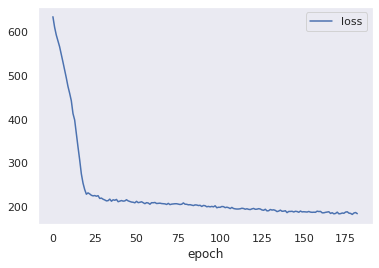

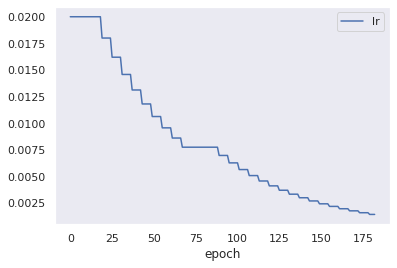

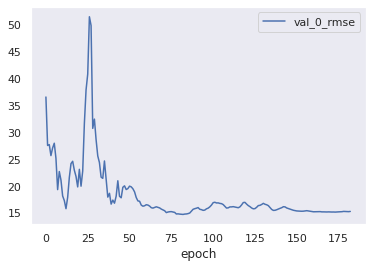

In [369]:
for param in ['loss', 'lr', 'val_0_rmse']:
    plt.plot(model.history[param], label=param)
    plt.xlabel('epoch')
    plt.grid()
    plt.legend()
    plt.show()

In [371]:
print('TabNet CV....','updrs_1:',scores_tn[0].round(2),'updrs_2:',scores_tn[1].round(2),'updrs_3:',scores_tn[2].round(2))

TabNet CV.... updrs_1: 5.33 updrs_2: 6.47 updrs_3: 14.75


In [383]:
models_tn = [model_tn_1,model_tn_2,model_tn_3]
df_test_val_tn = df_test_val.fillna(-1)
predict_test_val(df_test_val_tn,predict_order_list,models_tn,te_updrs_s) 

Score Test Val Predict :  12.572
Score Test Val Predict SMAPE :  57.558


<ipython-input-380-701b4e4ce40f>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_te_val.rename(columns={'updrs_{0}'.format(order):'updrs_{0}_te'.format(order)},inplace=True)


,id,true,pred,diff,diff_ratio
0,1517_0_updrs_1,11.0,5.800000,5.200000,47.0
1,1517_6_updrs_1,17.0,7.900000,9.100000,54.0
2,1517_12_updrs_1,20.0,6.300000,13.700000,68.0
3,1517_24_updrs_1,19.0,7.000000,12.000000,63.0
4,3863_0_updrs_1,8.0,6.300000,1.700000,21.0
5,3863_6_updrs_1,9.0,8.300000,0.700000,8.0
6,3863_12_updrs_1,11.0,7.400000,3.600000,33.0
7,3863_24_updrs_1,11.0,7.300000,3.700000,34.0
8,4923_0_updrs_1,2.0,5.200000,3.200000,160.0
9,4923_6_updrs_1,6.0,5.300000,0.700000,12.0


## predict Test for colab

In [ ]:
df_test_ = df_test.drop(['visit_id'],axis=1)

num_features_used = sum(model_1.get_feature_importance() > 0)
print("Number of features used:", num_features_used)

for order in predict_order_list:
  test_X = df_test_.values
  #test_y = df_test['updrs_{0}'.format(order)].values
  if order == 1:
        model_ = model_1
        df_te = te_updrs_1
  if order == 2:
        model_ = model_2
        df_te = te_updrs_2
  if order == 3:
        model_ = model_3
        df_te = te_updrs_3

  df_test_['updrs_{0}'.format(order)] = model_.predict(test_X)
  df_test_['updrs_{0}_round'.format(order)] = df_test_['updrs_{0}'.format(order)].round(0)
  #予測値のtarget-encodingテーブルをjoin
  df_te.rename(columns={'updrs_{0}'.format(order):'updrs_{0}_te'.format(order)},inplace=True)
  df_test_ = df_test_.merge(df_te,left_on='updrs_{0}_round'.format(order),right_on='updrs_{0}_te'.format(order),how='left')
  #不要列の削除
  df_test_.drop(['updrs_{0}_round'.format(order),'updrs_{0}_te'.format(order)],axis=1,inplace=True)

df_test_pred_ = df_test[['visit_id']].reset_index(drop=True).join(df_test_[['updrs_1','updrs_2','updrs_3']]).round(2)

df_test_pred = pd.DataFrame()
for i in range(0,3):
  df_test_pred_vs = pd.DataFrame()
  df_test_pred_vs['id'] = df_test_pred_[['visit_id']] + '_updrs_{0}'.format(i+1)
  df_test_pred_vs['updrs']=df_test_pred_[['updrs_{0}'.format(i+1)]]
  df_test_pred = pd.concat([df_test_pred,df_test_pred_vs],axis=0)

display(df_test_pred)

# Inference for kaggle notebook

## import Library

In [ ]:
if 'KAGGLE_URL_BASE' in set(os.environ.keys()):
  import amp_pd_peptide
  env = amp_pd_peptide.make_env()
  iter_test = env.iter_test()

In [ ]:
# def map_test(x):
#     updrs = x.split('_')[2] + '_' + x.split('_')[3]
#     month = int(x.split('_plus_')[1].split('_')[0])
#     visit_id = x.split('_')[0] + '_' + x.split('_')[1]
#     if updrs=='updrs_4':
#         rating = 0
#     elif updrs =='updrs_1':
#         rating = df[df.visit_id == visit_id]['pred1'].values[0]
#     elif updrs =='updrs_2':
#         rating = df[df.visit_id == visit_id]['pred2'].values[0]
#     else: #updrs =='updrs_3'
#         rating = df[df.visit_id == visit_id]['pred3'].values[0]
#     return rating

if 'KAGGLE_URL_BASE' in set(os.environ.keys()):
  counter = 0

  for (test, test_peptides, test_proteins, sample_submission) in iter_test:

    #1.common 特徴量の作成

    #2-1.predict to updrs_1

    #2-2.updrs_1を使った追加の特徴量作成

    #3-1.predict to updrs_2

    #3-2.updrs_1を使った追加の特徴量作成

    #4.predict to updrs_3
    
    #5.submissionの作成

    sample_submission['rating'] = sample_submission['prediction_id'].apply(map_test)
    env.predict(sample_submission)
    
    if counter == 0:
        display(test)
        display(sample_submission)
        
    counter += 1

In [ ]:

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=config.FRAC, random_state=config.RANDOM_STATE,shuffle=True)

# df_log = pd.DataFrame() #Log用DFの定義
# models = []                          # 各 fold のモデル
# scores = 0.0   
# best_score = np.inf
# preds = np.zeros(len(X_test))

# gf = GroupShuffleSplit(n_splits=config.N_FOLD,test_size=0.2,random_state=config.RANDOM_STATE)
# groups = X_train[:,0]

# for fold, (trn_idx, val_idx) in enumerate(gf.split(X_train,y_train,groups)):

#     X_trn, y_trn = X_train[trn_idx,:], y_train[trn_idx]
#     X_val, y_val = X_train[val_idx,:], y_train[val_idx]

#     train_pool = Pool(X_trn, y_trn)
#     validate_pool = Pool(X_val, y_val)

#     model = CatBoostRegressor(random_seed=config.RANDOM_STATE,logging_level='Silent',eval_metric = config.METRIC)
#     model.fit(train_pool, eval_set = validate_pool, early_stopping_rounds = 10, use_best_model=True, plot=False, verbose=False)  
    
#     score = score_cal(y_val,model.predict(X_val))
#     scores += score / config.N_FOLD
#     models.append(model)

#     if score < best_score:
#         best_score = score
#         best_model = model
#         best_fold = fold+1
#     print("Fold :" , fold+1)

# print(f"fold average score : {scores:.4f}")
# print(f"fold best score : {best_score:.4f}"," FOLD ",best_fold)
# #****************************
# # test データ

# # 各モデルで推論
# for model in models:
#     preds += model.predict(X_test) / len(models) 
# test_score = score_cal(y_test, preds)
# pred_best = best_model.predict(X_test)

# print(f"Test data average score : {test_score:.4f}"," seed ", config.RANDOM_STATE)
# print(f"Test data best socre : {score_cal(y_test, pred_best):.4f}"," seed ", config.RANDOM_STATE)
# print("***********************")
# #display_feature_importance(train_column_list,best_model)
# feature_importance = pd.DataFrame()
# feature_importance['feature'] = train_column_list
# feature_importance['importance'] = best_model.feature_importances_

# feature_importance.groupby("feature")["importance"].mean().sort_values(ascending=False)[:30]

#TESTのaftermonth予測用。trainから現状とnextの情報を予測する

In [ ]:
# 特定の文字列を含む列名を変換する関数
def rename_columns(old_name):
    new_name = old_name.replace('_after', '')
    return new_name

In [ ]:
#資材あつめ
train_clinical
train_peptides
train_proteins

print(train_peptides['UniProt'].nunique(),train_peptides['Peptide'].nunique(),train_proteins['UniProt'].nunique())
print(test_peptides['UniProt'].nunique(),test_peptides['Peptide'].nunique(),test_proteins['UniProt'].nunique())
# 227,968,227
# 236,1077,236  -> TESTのほうが、uniとpep多い。無視するしかない


train_clinical_shift = train_clinical.drop(['upd23b_clinical_state_on_medication'],axis=1).join(train_clinical.drop(['visit_id','upd23b_clinical_state_on_medication'],axis=1).groupby('patient_id').shift(-1),rsuffix='_after')
train_clinical_shift.dropna(subset=['visit_month_after'], inplace=True)
train_clinical_shift.describe()


train_clinical_shift_pred = train_clinical_shift[['visit_month','updrs_1','updrs_2','updrs_3','visit_month_after','updrs_1_after','updrs_2_after','updrs_3_after']]

X = train_clinical_shift_pred.drop(['updrs_1_after','updrs_2_after','updrs_3_after'],axis=1).values
y = train_clinical_shift_pred['updrs_1_after'].values
model_u1,score = fit_catboost_fold1(X,y)

X = train_clinical_shift_pred.drop(['updrs_1_after','updrs_2_after','updrs_3_after'],axis=1).values
y = train_clinical_shift_pred['updrs_2_after'].values
model_u2,score = fit_catboost_fold1(X,y)

X = train_clinical_shift_pred.drop(['updrs_1_after','updrs_2_after','updrs_3_after'],axis=1).values
y = train_clinical_shift_pred['updrs_3_after'].values
model_u3,score = fit_catboost_fold1(X,y)

display_feature_importance(train_clinical_shift_pred.drop(['updrs_1_after','updrs_2_after','updrs_3_after'],axis=1).columns,model_u2)


In [ ]:
#EDA
train_clinical_shift_pred[train_clinical_shift_pred['visit_month'] == 0][['updrs_1','updrs_1_after']].groupby('updrs_1').mean().reset_index()
#train_clinical_shift_pred.info()

train_clinical_shift_pred_24 = train_clinical_shift_pred[train_clinical_shift_pred['visit_month'] <= 24]
train_shift_24_pivot=train_clinical_shift_pred_24.pivot_table(index=['visit_month'], aggfunc='mean').reset_index()

from sklearn.linear_model import LinearRegression

coef_intercept_df = pd.DataFrame(columns=['coef', 'intercept'])
for i in range(1, len(train_shift_24_pivot.columns)):
    X = train_shift_24_pivot['visit_month'].values.reshape(-1,1)
    y = train_shift_24_pivot.iloc[:, i].values
    reg = LinearRegression().fit(X, y)
    coef_intercept_df.loc[i] = [reg.coef_[0], reg.intercept_]

coef_intercept_df

In [ ]:
df_test_shift_pred = df_test_pred_.copy()
df_test_shift_pred.drop(['visit_id'],axis=1,inplace=True)
df_test_shift_pred['visit_month']=0
df_test_shift_pred_sum = pd.DataFrame()


for i in range(0,7):
  i_month = i * 6
  df_test_shift_pred['visit_month_after']=df_test_shift_pred['visit_month'] + 6

  df_test_shift_pred['updrs_1_after'] = model_u1.predict(df_test_shift_pred)
  df_test_shift_pred['updrs_2_after'] = model_u2.predict(df_test_shift_pred)
  df_test_shift_pred['updrs_3_after'] = model_u3.predict(df_test_shift_pred)

  df_test_shift_pred_new=df_test_shift_pred[['updrs_1_after','updrs_2_after','updrs_3_after','visit_month_after']]

  df_test_shift_pred_sum = pd.concat([df_test_shift_pred_sum,df_test_shift_pred])

  # 全ての列名にrename_columns関数を適用する
  new_columns = [rename_columns(col_name) for col_name in df_test_shift_pred_new.columns]
  # 新しいdataframeにコピーする
  df_test_shift_pred_new.columns = new_columns
  df_test_shift_pred = df_test_shift_pred_new
  
display(df_test_shift_pred_sum)